In [ ]:
!pip install pyjanitor pyvis --quiet

     |████████████████████████████████| 107 kB 5.4 MB/s 


In [ ]:
import pandas as pd
import janitor
import datetime

from IPython.core.display import display, HTML
from pyvis import network as net
import networkx as nx

In [ ]:
df_ori = pd.read_csv("/content/drive/MyDrive/linkedin_network/Connections.csv", skiprows=2)

In [ ]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2757 entries, 0 to 2756
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     2747 non-null   object
 1   Last Name      2747 non-null   object
 2   Email Address  71 non-null     object
 3   Company        2668 non-null   object
 4   Position       2668 non-null   object
 5   Connected On   2757 non-null   object
dtypes: object(6)
memory usage: 129.4+ KB


## Data Cleaning

In [ ]:
df = (
    df_ori
    .clean_names() # remove spacing and capitalization
    .drop(columns=['first_name', 'last_name', 'email_address']) # drop for privacy
    .dropna(subset=['company', 'position']) # drop missing values in company and position
    .to_datetime('connected_on', format='%d %b %Y')
  )
df.head()

,company,position,connected_on
0,ClosedLoop.ai,Data Scientist,2021-10-25
1,Freelance,IT Support,2021-10-19
2,Erupture Angel Network,Data Partner,2021-10-18
3,Digital Marketing Networks Sdn Bhd,Digital Marketing Trainer & Consultant,2021-10-17
4,SECURITI.ai,Marketing Team Lead,2021-10-16


## Simple EDA

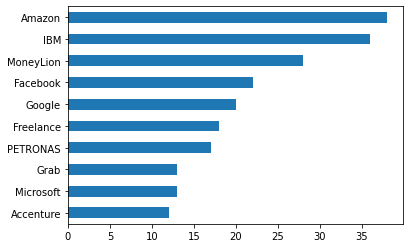

In [ ]:
df['company'].value_counts().head(10).plot(kind="barh").invert_yaxis();

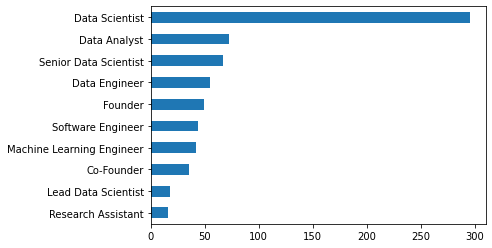

In [ ]:
df['position'].value_counts().head(10).plot(kind="barh").invert_yaxis();

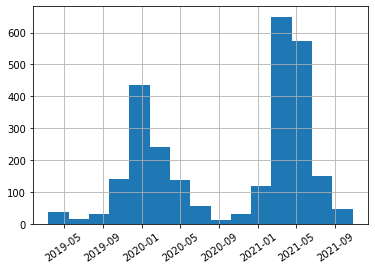

In [ ]:
df['connected_on'].hist(xrot=35, bins=15);

### Remove freelance and self-employed titles

In [ ]:
pattern = "freelance|self-employed"
df = df[~df['company'].str.contains(pattern, case=False)]

## Aggregate sum of connections for companies

In [ ]:
df_company = df['company'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by="count", ascending=False)
df_company.head(10)

,company,count
0,Amazon,38
1,IBM,36
2,MoneyLion,28
3,Facebook,22
4,Google,20
5,PETRONAS,17
6,Grab,13
7,Microsoft,13
8,Accenture,12
9,Medium,12


## Aggregate sum of connections for positions

In [ ]:
df_position = df['position'].value_counts().reset_index()
df_position.columns = ['position', 'count']
df_position = df_position.sort_values(by="count", ascending=False)
df_position.head(10)

,position,count
0,Data Scientist,293
1,Data Analyst,71
2,Senior Data Scientist,67
3,Data Engineer,55
4,Founder,49
5,Software Engineer,44
6,Machine Learning Engineer,41
7,Co-Founder,35
8,Lead Data Scientist,18
9,Research Assistant,16


## Creating the network

### Example of simple network

In [ ]:
nt = net.Network(notebook=True)

g = nx.Graph()
g.add_node(0, label = "root") # intialize yourself as central node
g.add_node(1, label = "Company 1", size=10, title="info1")
g.add_node(2, label = "Company 2", size=40, title="info2")
g.add_node(3, label = "Company 3", size=60, title="info3")
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(0, 3)

nt.from_nx(g)
nt.show('nodes.html')
display(HTML('nodes.html'))

In [ ]:
print(f"number of nodes: {g.number_of_nodes()}")
print(f"number of edges: {g.number_of_edges()}")

number of nodes: 4
number of edges: 3


In [ ]:
for _, row in df_company.head(5).iterrows():
  print(row['company'] + "-" + str(row['count']))

Amazon-38
IBM-36
MoneyLion-28
Facebook-22
Google-20


In [ ]:
print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=5]
print(df_company_reduced.shape)

(1956, 2)
(45, 2)


In [ ]:
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=5]
print(df_position_reduced.shape)

(1535, 2)
(47, 2)


In [ ]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_company_reduced.iterrows():

  # store company name and count
  company = row['company']
  count = row['count']

  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in df[company == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))

In [ ]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_position_reduced.iterrows():

  count = f"{row['count']}"
  position= row['position']
  
  g.add_node(position, size=count, color='#3449eb', title=count)
  g.add_edge('root', position, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('position_graph.html')
display(HTML('position_graph.html'))